# Initial SetUp

In [60]:
!pip install super-gradients==3.1.0
!pip install imutils
!pip install roboflow
!pip install pytube --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached pyparsing-2.4.5-py2.py3-none-any.whl (67 kB)
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 2.4.7
    Uninstalling pyparsing-2.4.7:
      Successfully uninstalled pyparsing-2.4.7
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
roboflow 1.0.8 requires pyparsing==2.4.7, but you have pyparsing 2.4.5 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached pyparsing-2.4.7-py2.py3-none-any.whl (67 kB)
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 2.4.5
    Uninstalling pyparsing-2.4.5:
      Successfully uninstalled py

In [61]:
from super_gradients.training import models
from super_gradients.common.object_names import Models

In [62]:
# Get pre trained weights

# model = models.get(Models.YOLO_NAS_L, pretrained_weights="coco")

In [63]:
# Install SAM
!pip install git+https://github.com/facebookresearch/segment-anything.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-a76qk4v7
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-a76qk4v7
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done


In [64]:
import torch
torch.__version__

'1.13.1+cu117'

In [65]:
torch.cuda.get_device_name(0)

'Tesla T4'

# SAM SETUP

In [66]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

Helper Function

In [67]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

# Automatic mask generation
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

# Load Ip Image

In [68]:
image = cv2.imread('/content/drive/MyDrive/Colab_Notebooks/ObjectDetection/YoloNAS_SAM/images/person_04.jpeg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

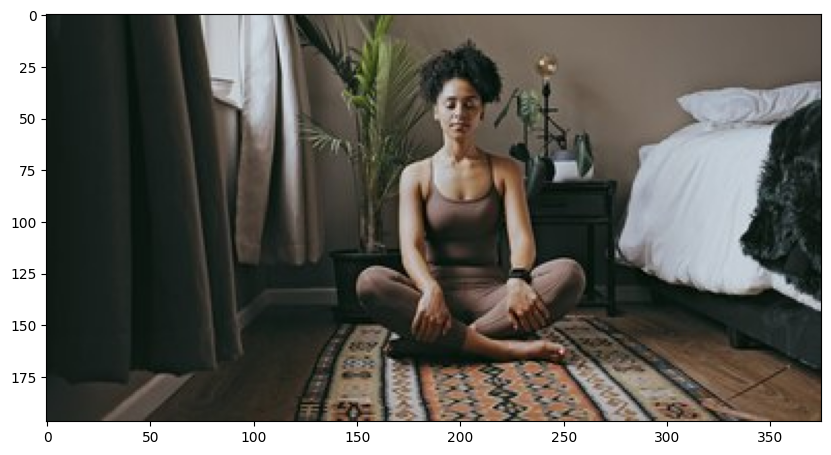

In [69]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

# OD - YOLO_NAS

In [70]:
from super_gradients.training import models

yolo_nas_l = models.get("yolo_nas_l", pretrained_weights="coco")

[2023-05-14 19:30:02] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.


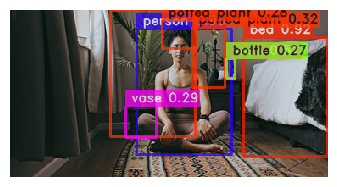

In [71]:
yolo_nas_l.predict(image, conf=0.25).show()

Save to output folder

In [72]:
conf_threshold = 0.25
detection_pred = yolo_nas_l.predict(image, conf = conf_threshold)
detection = detection_pred.save('/content/drive/MyDrive/Colab_Notebooks/ObjectDetection/YoloNAS_SAM/output')

# SAM

In [73]:
from segment_anything import sam_model_registry, SamPredictor
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "/content/drive/MyDrive/Colab_Notebooks/ObjectDetection/YoloNAS_SAM/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)
mask_generator = SamAutomaticMaskGenerator(sam)


In [74]:
predictor.set_image(image)
masks = mask_generator.generate(image)

In [75]:
print(len(masks))
print(masks[0].keys())

75
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


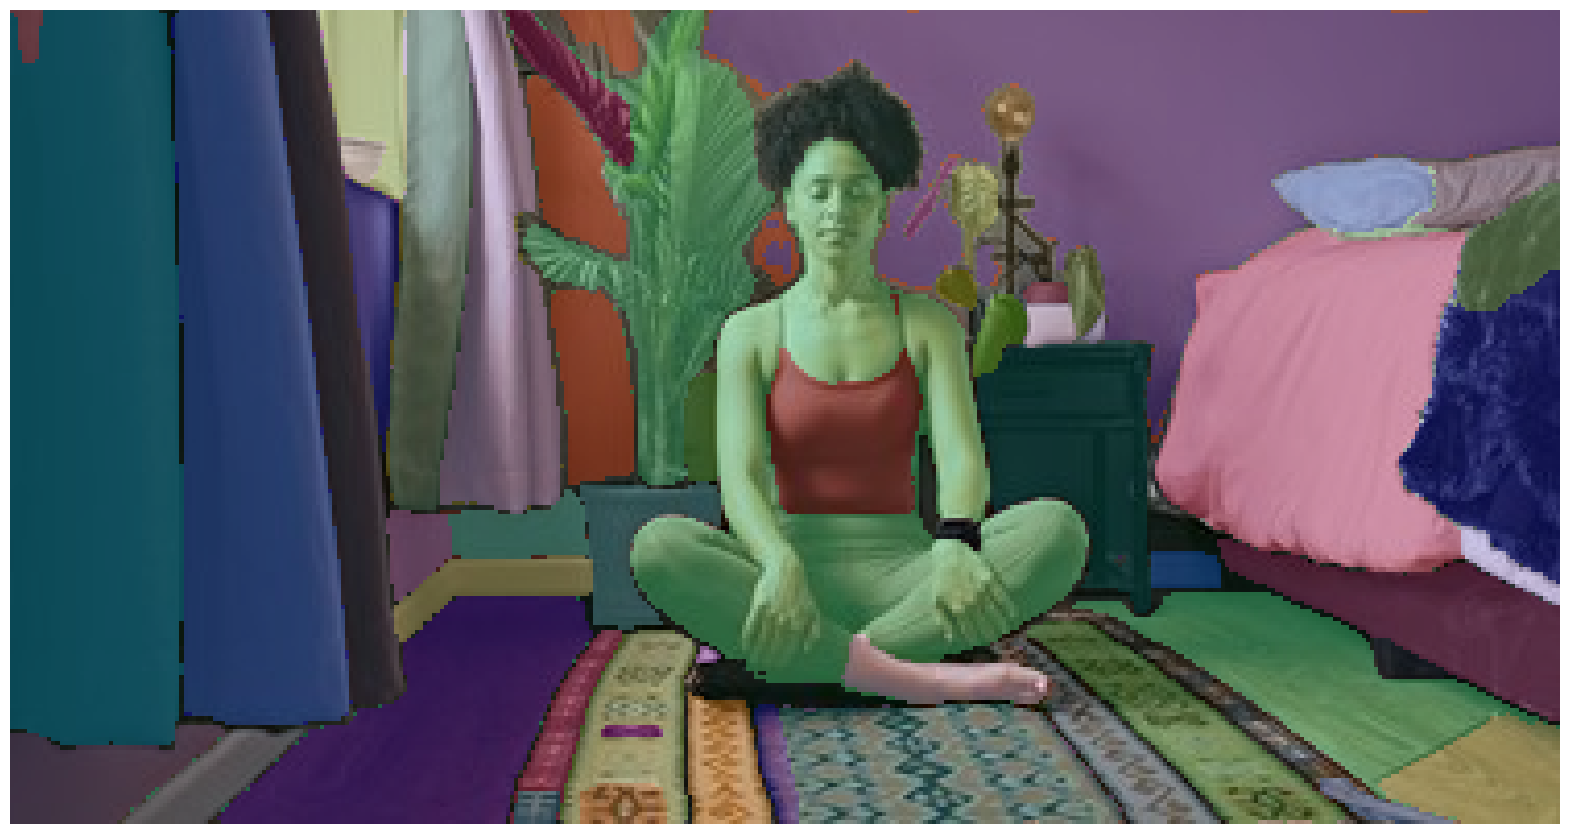

In [76]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

# YOLO_NAS + SAM = For segmenting and detecting specific class

Steps:
1. Object detection using NAS.
2.Provide Bounding Box Coordinates to SAM.
3. SAM provides mask.


In [77]:
from super_gradients.training import models

model_nas = models.get("yolo_nas_l", pretrained_weights="coco")
conf_threshold = 0.25


[2023-05-14 19:30:46] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.


In [78]:
model_pred = list(model_nas.predict(image, conf = conf_threshold)._images_prediction_lst)

In [79]:
model_pred

[ImageDetectionPrediction(image=array([[[ 21,  30,  27],
         [ 20,  29,  26],
         [ 23,  32,  29],
         ...,
         [ 95,  86,  79],
         [ 95,  86,  79],
         [ 95,  86,  79]],
 
        [[ 20,  29,  26],
         [ 19,  28,  25],
         [ 22,  31,  28],
         ...,
         [ 95,  86,  79],
         [ 95,  86,  79],
         [ 95,  86,  79]],
 
        [[ 19,  28,  25],
         [ 18,  27,  24],
         [ 22,  31,  28],
         ...,
         [ 96,  87,  80],
         [ 95,  86,  79],
         [ 95,  86,  79]],
 
        ...,
 
        [[ 31,  37,  35],
         [ 32,  38,  36],
         [ 32,  38,  34],
         ...,
         [121,  97,  73],
         [121,  97,  73],
         [104,  80,  56]],
 
        [[ 31,  37,  35],
         [ 32,  38,  36],
         [ 32,  38,  34],
         ...,
         [119,  95,  71],
         [112,  88,  64],
         [100,  76,  52]],
 
        [[ 31,  37,  35],
         [ 32,  38,  36],
         [ 32,  38,  34],
         ..

In [80]:
model_pred[0].prediction

DetectionPrediction(bboxes_xyxy=array([[1.49688431e+02, 2.21567326e+01, 2.61553314e+02, 1.70815018e+02],
       [2.75448669e+02, 3.26741600e+01, 3.74311279e+02, 1.72373001e+02],
       [1.18795921e+02, 1.65894344e-01, 2.18327133e+02, 1.49259079e+02],
       [2.55574478e+02, 5.73365707e+01, 2.65345001e+02, 8.01502380e+01],
       [2.15858337e+02, 2.06082897e+01, 2.53251373e+02, 9.12521591e+01],
       [1.36509216e+02, 1.13321335e+02, 1.72480194e+02, 1.50199585e+02],
       [1.79954865e+02, 1.26440477e+01, 2.20887848e+02, 4.51118507e+01],
       [2.55642441e+02, 5.71579475e+01, 2.65359711e+02, 8.02338943e+01]],
      dtype=float32), confidence=array([0.94699377, 0.9198026 , 0.5979191 , 0.5125523 , 0.31911057,
       0.28713065, 0.28487423, 0.2694736 ], dtype=float32), labels=array([ 0., 59., 58., 75., 58., 75., 58., 39.], dtype=float32))

In [81]:
bboxes_xyxy = model_pred[0].prediction.bboxes_xyxy.tolist()
bboxes_xyxy

[[149.6884307861328, 22.1567325592041, 261.5533142089844, 170.8150177001953],
 [275.44866943359375, 32.67416000366211, 374.311279296875, 172.3730010986328],
 [118.7959213256836,
  0.16589434444904327,
  218.32713317871094,
  149.2590789794922],
 [255.57447814941406,
  57.336570739746094,
  265.3450012207031,
  80.15023803710938],
 [215.85833740234375,
  20.60828971862793,
  253.25137329101562,
  91.25215911865234],
 [136.50921630859375,
  113.32133483886719,
  172.48019409179688,
  150.1995849609375],
 [179.95486450195312,
  12.644047737121582,
  220.88784790039062,
  45.11185073852539],
 [255.64244079589844, 57.1579475402832, 265.3597106933594, 80.23389434814453]]

In [82]:
# Extract desired outputs
bboxes_xyxy = model_pred[0].prediction.bboxes_xyxy.tolist()
confidence = model_pred[0].prediction.confidence.tolist()
labels = model_pred[0].prediction.labels.tolist()

In [83]:
print("Bounding Boxes (xyxy):", bboxes_xyxy)
print("Confidence:", confidence)
print("Labels:", labels)

SAM

In [91]:
sam_checkpoint = "/content/drive/MyDrive/Colab_Notebooks/ObjectDetection/YoloNAS_SAM/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)
masks = mask_generator.generate(image)

In [92]:
predictor.set_image(image)

In [93]:
# image = image.transpose((2,0,1)) # transpose to match SAM input format
# image = image / 255.0 # Normalize image value to (0,1)
# image = np.expand_dims(image, axis = 0)

In [94]:
input_box = np.array(bboxes_xyxy[0])

In [100]:
if labels[0] == 0:
  masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box = input_box[None, : ],
    multimask_output=False,
)

In [101]:
masks.shape

(1, 197, 375)

In [102]:
masks

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])

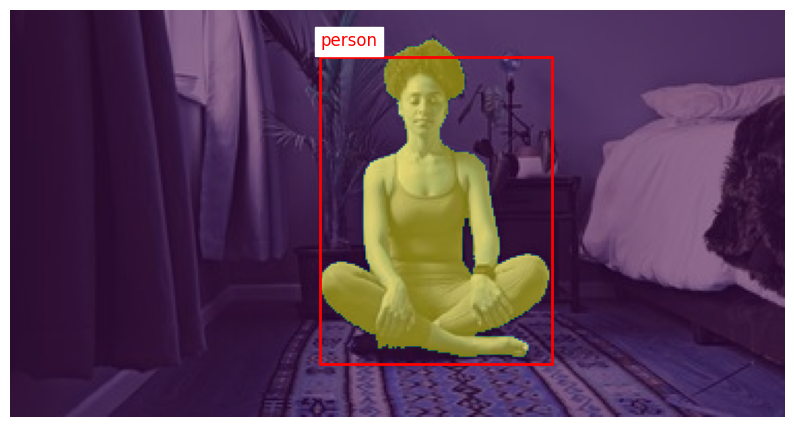

In [104]:
plt.figure(figsize = (10,10))
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))

if labels[0] == 0:
  plt.imshow(masks[0], alpha = 0.5)
plt.gca().add_patch(plt.Rectangle((input_box[0],input_box[1]), input_box[2] - input_box[0], input_box[3] - input_box[1],
                                   linewidth = 2, edgecolor = 'r', facecolor='none'))

plt.text(input_box[0], input_box[1] - 5, 'person', fontsize=12, color='r',backgroundcolor='w')
plt.axis('off')
plt.savefig('/content/drive/MyDrive/Colab_Notebooks/ObjectDetection/YoloNAS_SAM/output/' + 'op2.png')
plt.show()